## Implement of a curvature tensor

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import pandas as pd

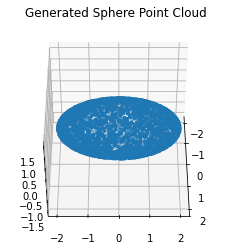

In [16]:
def generate_ellipsoid_cloud(a, b, c, num_points = 5000):
    """Generate a random point on an ellipsoid defined by a,b,c"""
    
    theta = np.random.uniform(0, 2*np.pi, num_points)
    v = np.random.rand(num_points)
    phi = np.arccos(2.0 * v - 1.0)
    sinTheta = np.sin(theta);
    cosTheta = np.cos(theta);
    sinPhi = np.sin(phi);
    cosPhi = np.cos(phi);
    rx = a * sinPhi * cosTheta;
    ry = b * sinPhi * sinTheta;
    rz = c * cosPhi;
    return np.column_stack((rx, ry, rz))


ellipsoid = generate_ellipsoid_cloud(1, 2, 1)

# Visualize the point cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ellipsoid[:, 0], ellipsoid[:, 1], ellipsoid[:, 2], s=5)
ax.set_aspect('equal')
ax.set_title("Generated Sphere Point Cloud")
ax.view_init(45, 0)
plt.show()

In [65]:
def find_basis(point_cloud, x, k_pca = 100, k_transport = 200, dim = 2, epsilon_PCA = 0.2):
    #point_cloud: the manifold 
    #x: np.array of shape 1 by p, the points where the curvature is evaluated at, e.g., [[1, 2, 3]]
    #k_pca: the number of points to use for PCA
    #k_transport: the number of points to use for triangulation
    #dim: the dimension of the manifold

    # Create a NearestNeighbors model
    
    # Find transport neighborhood
    
    tau_nbrs = NearestNeighbors(n_neighbors=k_transport, algorithm='ball_tree').fit(point_cloud)
    tau_nbrs = point_cloud[tau_nbrs.kneighbors(x, return_distance=False)][0]
    
    pca_nbrs = NearestNeighbors(n_neighbors=k_pca, algorithm='ball_tree').fit(point_cloud)
    dist, pca_tau_indx = pca_nbrs.kneighbors(tau_nbrs)
    
    pca_tau_nbrs = point_cloud[pca_tau_indx]
    
    
    list_X_i = pca_tau_nbrs - np.expand_dims(tau_nbrs, axis=1)
    
    num = len(dist)
    #list_D_i = [np.diag(np.sqrt(np.exp(- np.array(dist[i]) ** 2 / epsilon_PCA))) for i in range(num)]
    list_D_i = [np.diag(np.sqrt(np.exp( - 5 * np.array(dist[i]) ** 2 / epsilon_PCA))) for i in range(num)]
    list_B_i = [list_X_i[j].T @ list_D_i[j] for j in range(num)]
    O = []
    for q in range(num):
        U, S, VT = np.linalg.svd(list_B_i[q], full_matrices = False)
        O_i = U[:, :dim]
        O.append(O_i)
        
    return tau_nbrs, pca_tau_nbrs, O



In [53]:
x = np.array([ellipsoid[1]])
A, B, C = find_basis(ellipsoid, x, k_pca = 10, k_transport = 5, dim = 2)

In [51]:
C

[array([[-0.60490431, -0.78512048],
        [ 0.60828943, -0.56334657],
        [-0.51388204,  0.25734504]]),
 array([[-0.3617752 , -0.91647725],
        [ 0.72990772, -0.3924559 ],
        [-0.57995984,  0.07776771]]),
 array([[-0.43729553, -0.89266071],
        [ 0.71587305, -0.41902869],
        [-0.54433298,  0.16604761]]),
 array([[-0.51163354,  0.84198187],
        [-0.76042516, -0.35099804],
        [ 0.39998088,  0.40971565]]),
 array([[-0.90521513,  0.37830509],
        [-0.42166008, -0.74299852],
        [ 0.05280479,  0.55212178]])]

In [54]:
C

[array([[-0.60358581, -0.78587228],
        [ 0.60875279, -0.56318191],
        [-0.51488271,  0.25540341]]),
 array([[-0.34863514, -0.92159891],
        [ 0.73561679, -0.38186001],
        [-0.58079383,  0.06955848]]),
 array([[-0.49417892, -0.8623478 ],
        [ 0.68716501, -0.46510703],
        [-0.53253304,  0.20007928]]),
 array([[-0.52108488,  0.83621006],
        [-0.75622212, -0.35947227],
        [ 0.39572549,  0.41416472]]),
 array([[-0.90282412,  0.38425344],
        [-0.42610661, -0.73908807],
        [ 0.05780806,  0.55326135]])]

## Use triangle

In [66]:
def sheaf_cur_tensor(point_cloud, query_point, k_pca = 50, k_transport = 300, dim = 2, epsilon_PCA = 0.4):
    
    tau_nbr, pca_tau_nbr, O = find_basis(point_cloud, query_point, 
                                         k_pca = k_pca, k_transport = k_transport, dim = dim, epsilon_PCA = epsilon_PCA)

    transport_maps = np.zeros((len(tau_nbr), len(tau_nbr), dim, dim))
    for i in range(len(tau_nbr)):
        for j in range(len(tau_nbr)):
            U, S, VT = np.linalg.svd(O[i].T @ O[j], full_matrices = False)
            O_ij = U @ VT
            transport_maps[i,j] = O_ij
            
    tensor_av = []
    
    O_init = O[0].T  # this is the basis at point o, it is 2 x 3
    v_init =  tau_nbr[1] - tau_nbr[0] #choose the initial vector
    v_0 = np.array([np.dot(v_init, O_init[0]), np.dot(v_init, O_init[1])]) #change that vector to the coord w.r.t the basis O_init
    for i in np.arange(1, len(tau_nbr)):
        for j in np.arange(i + 1, len(tau_nbr)):
            v_fin = transport_maps[j, 0] @ transport_maps[i, j] @ transport_maps[0, i] @ v_0 #final vector of the form (a, b)
            v_fin = v_fin[0] * O_init[0] + v_fin[1] * O_init[1]  #change it to the vector form of coord (x, y, z)
            
            cosin = (v_init @ v_fin.T) / (np.linalg.norm(v_init) * np.linalg.norm(v_fin))
            if cosin>1: cosin = 1
            if cosin<-1: cosin = -1
            angle = np.arccos(cosin)
            area = np.linalg.norm(np.cross(tau_nbr[i] - tau_nbr[0], tau_nbr[j] - tau_nbr[0])) / 2
            
            #tensor = angle / area
            tensor = (2 * np.pi - angle) / area 
            
            tensor_av.append(tensor)
            
            #tensor = angle / area                                  

    
    
    tensor_av = np.exp(sum(tensor_av)/len(tensor_av) * 0.0001)
         
    return transport_maps, tensor_av 
 

In [67]:
num_eval = int(len(ellipsoid)/5)

curvature = []
for i in tqdm(range(num_eval)):
    a, b = sheaf_cur_tensor(ellipsoid, np.expand_dims(ellipsoid[i], axis=0), epsilon_PCA = 0.2)
    curvature.append(b)


100%|██████████| 1000/1000 [52:32<00:00,  3.15s/it]


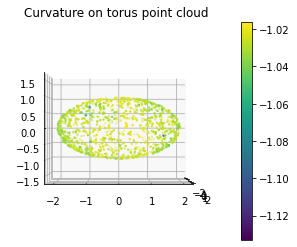

In [68]:
v = np.array(curvature).T
# Visualize the point cloud
cc = -v
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(ellipsoid[:num_eval, 0], ellipsoid[:num_eval, 1], ellipsoid[:num_eval, 2], s=2, c = cc)
ax.set_title("Curvature on torus point cloud")
ax.view_init(0, 0)
plt.colorbar(scatter)
ax.set_aspect('equal')
plt.show()

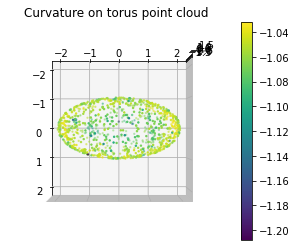

In [27]:
v = np.array(curvature).T
# Visualize the point cloud
cc = - v
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(ellipsoid[:num_eval, 0], ellipsoid[:num_eval, 1], ellipsoid[:num_eval, 2], s=2, c = cc)
ax.set_title("Curvature on torus point cloud")
ax.view_init(90, 0)
plt.colorbar(scatter)
ax.set_aspect('equal')
plt.show()

In [5]:
import numpy as np
import random

# Constants
G = 6.67430e-11  # Gravitational constant in m^3/kg/s^2
c = 299792458.0  # Speed of light in m/s
M = 1.989e30  # Mass of a typical black hole in kg (e.g., 1 solar mass)

# Define Schwarzschild metric components
def schwarzschild_metric(r, theta, phi):
    # Metric components
    g_tt = -(1 - 2 * G * M / (c**2 * r))
    g_rr = 1 / (1 - 2 * G * M / (c**2 * r))
    g_theta_theta = r**2
    g_phi_phi = r**2 * np.sin(theta)**2

    return g_tt, g_rr, g_theta_theta, g_phi_phi

# Sample points from Schwarzschild spacetime
def sample_schwarzschild_points(num_samples):
    points = []
    
    for _ in range(num_samples):
        # Generate random coordinates within reasonable bounds
        r = random.uniform(2 * G * M / (c**2), 10 * G * M / (c**2))  # Restrict r to avoid singularities
        theta = random.uniform(0, np.pi)
        phi = random.uniform(0, 2 * np.pi)
        
        # Compute metric components at the sampled point
        g_tt, g_rr, g_theta_theta, g_phi_phi = schwarzschild_metric(r, theta, phi)
        
        # Sample a random time coordinate within a reasonable range
        t = random.uniform(0, 2 * np.pi * r * np.sqrt(-g_tt))
        
        # Append the sampled point as a tuple (t, r, theta, phi)
        points.append((t, r, theta, phi))
    
    return points

# Number of points to sample
num_samples = 5000

# Sample points from the Schwarzschild spacetime manifold
sampled_points = sample_schwarzschild_points(num_samples)

# Print the first few sampled points as an example
for i in range(5):
    print(f"Sampled Point {i + 1}: {sampled_points[i]}")


Sampled Point 1: (23863.81403823178, 6222.148940740963, 0.21995111339846912, 4.199522961707906)
Sampled Point 2: (35525.50810840895, 14243.248820686209, 2.0790691965741424, 3.628700407205624)
Sampled Point 3: (22507.26435432316, 9802.414756823386, 2.128364771517727, 5.42915365590317)
Sampled Point 4: (12952.694055043066, 12147.747391373377, 2.0828072008880762, 3.514790745584077)
Sampled Point 5: (9225.128236061999, 7160.125255415809, 0.3401291289219557, 0.10408772154468328)
